In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn
import math
from sklearn.datasets import make_moons

# Dataset

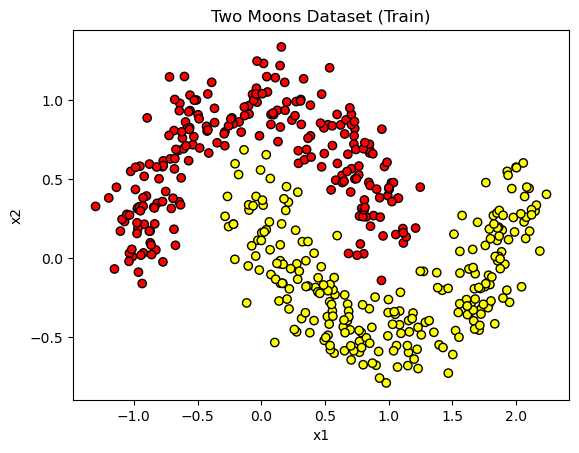

In [2]:
def make_two_moons(n_per_class=300, noise=0.15, seed=0):
    
    X, y = make_moons(
        n_samples=2 * n_per_class,
        noise=noise,
        random_state=seed
    )
    return X, y


# Generate dataset
X, y = make_two_moons(n_per_class=300, noise=0.15, seed=0)
N = len(X)

# Shuffle
rng = np.random.default_rng(seed=0)
perm = rng.permutation(N)

X = X[perm]
y = y[perm]

# Train / test split
n_train = int(0.8 * N)

X_train = X[:n_train]
y_train = y[:n_train]
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test  = X[n_train:]
y_test  = y[n_train:]
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Plot
plt.figure()
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    cmap='autumn',
    edgecolor='k'
)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Two Moons Dataset (Train)")
plt.show()


# Simple feed forward Neural Netweok

### Step by step:

1) nn.Linear(2, 100) = Takes 2D input outputs 100 dimensional hidden representation (netwoek learns 100 nonlinear features)
2) nn.ReLU() = max(0,z), essentially zeros negitive values
3) nn.Linear(100, 10) = Reduces 100 hidden features down to 10 (Compresses meaningful information)
4) nn.ReLU() = Same again
5) nn.Linear(10, 1)) = Outputs a single real number
6) Activation Function: torch.sigmoid(h).squeeze(1) = Converts number to a probability

In [3]:
class SimpleNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
                        nn.Linear(2, 100),
                        nn.ReLU(), 
                        nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))

    def forward(self, x):
        h = self.net(x)
        return torch.sigmoid(h).squeeze(1)
    
network = SimpleNetwork()

## Helper Functions

In [4]:
def log_likelihood(network, X, y):   
    y_hat = network(X)
    return dist.Bernoulli(y_hat).log_prob(y).sum()

def log_prior(network):
    log_prob = 0.0
    for p in network.parameters():
        log_prob = log_prob  + dist.Normal(0, 1).log_prob(p).sum()
    return log_prob

def log_joint_minibatch(network, X_batch, y_batch, N_training):
    lp = log_prior(network)
    ll_batch = log_likelihood(network, X_batch, y_batch)
    batch_size = X_batch.shape[0]
    return lp + ll_batch * N_training / batch_size


def log_joint_full(network, X_full, y_full):
    lp = log_prior(network)
    ll = log_likelihood(network, X_full, y_full)  # sum over all data
    return lp + ll


# Train the model (MAP estimation) 

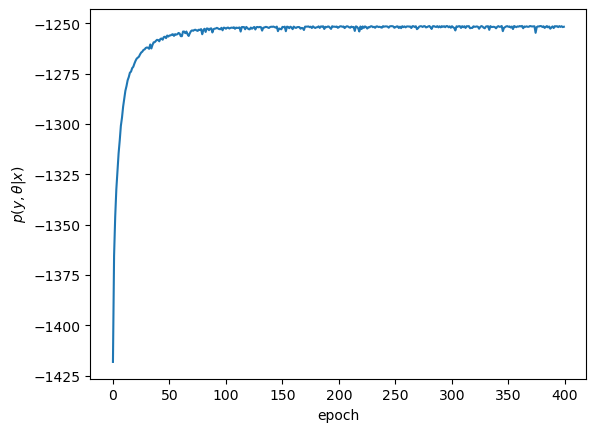

In [5]:
dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

opt = torch.optim.Adam(network.parameters())

N_epochs = 400
train_lp = []

for epoch in range(N_epochs):
    for X, y in dataloader:
        opt.zero_grad()
        loss = -log_joint_minibatch(network, X, y, len(dataset))
        loss.backward()
        opt.step()
    with torch.no_grad():
        train_lp.append((log_likelihood(network, X_train, y_train) + log_prior(network)).item())
plt.plot(train_lp)
plt.xlabel("epoch")
plt.ylabel("$p(y, \\theta | x)$");

## Non-Bayesian confidence plot

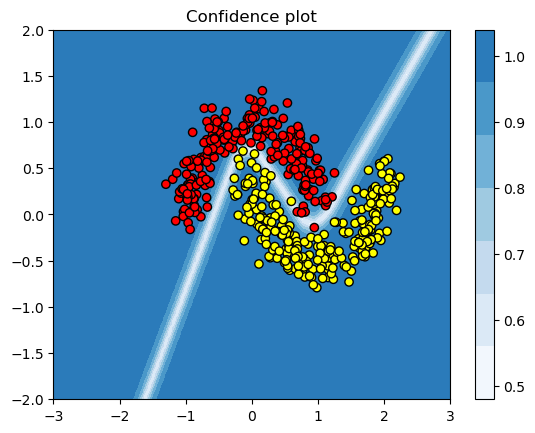

In [6]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))
with torch.no_grad():
    py = network(torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T))
    conf = torch.where(py > 0.5, py, 1-py)
    ZZ = conf.reshape(XX.shape)
CS = plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.5, vmax=1.2)
plt.colorbar(ticks=np.linspace(0.5, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k')
plt.title("Confidence plot");

# Sampling Algorithm SGLD

In [7]:
def SGLD_step(network, X, y, N_training, epsilon):
    network.zero_grad()
    lp = log_joint_minibatch(network, X, y, N_training)
    lp.backward()

    with torch.no_grad():
        for p in network.parameters():
            p += 0.5*epsilon**2 * p.grad + epsilon*torch.randn(p.shape) 

## Cyclic learning rate 

In [8]:
# Cyclic Learning
def learning_rate_schedule(N_steps, N_samples, epsilon):
    return epsilon * (np.cos(np.pi * (np.arange(N_samples*N_steps) % N_steps)/N_steps) + 1)

# old Learning scheme
def learning_rate_schedule_old(N_steps, N_samples, epsilon, alpha=0.55):
    T = N_steps * N_samples
    t = np.arange(T)
    return epsilon / (1.0 + t)**alpha


## Graph (For report)

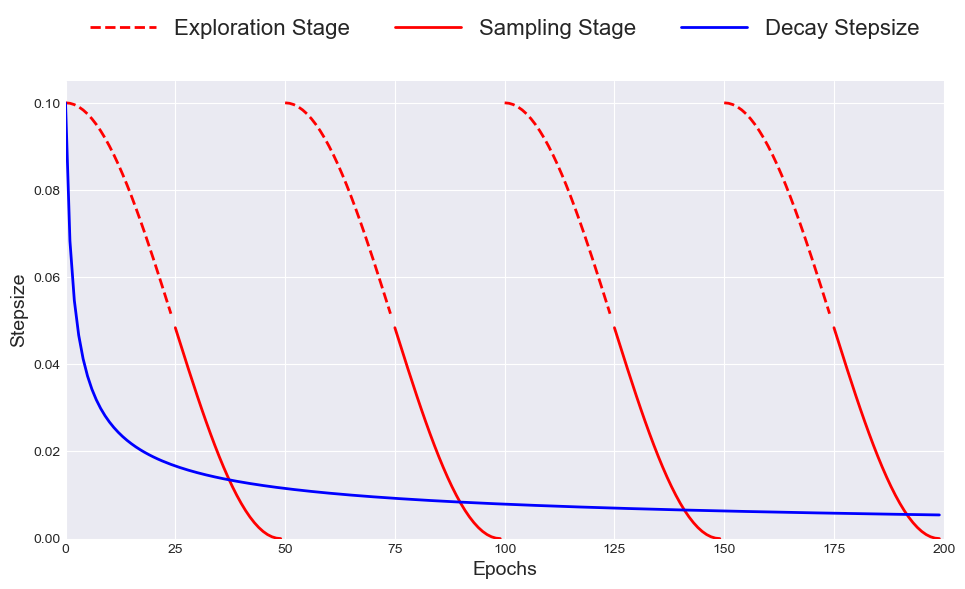

In [9]:
plt.style.use("seaborn-v0_8-darkgrid")

T = 200               
cycle_len = 50         
eps0 = 0.10            
explore_frac = 0.5     

epochs = np.arange(T)
pos_in_cycle = epochs % cycle_len
tau = pos_in_cycle / (cycle_len - 1) 
eps_cyclic = 0.5 * eps0 * (np.cos(np.pi * tau) + 1)

alpha = 0.55
eps_decay = eps0 / (1.0 + epochs) ** alpha

fig, ax = plt.subplots(figsize=(10, 6))

explore_mask = pos_in_cycle < int(cycle_len * explore_frac)
sample_mask  = ~explore_mask

eps_explore = np.where(explore_mask, eps_cyclic, np.nan)
eps_sample  = np.where(sample_mask,  eps_cyclic, np.nan)

ax.plot(epochs, eps_explore, linestyle="--", linewidth=2, color="red", label="Exploration Stage")
ax.plot(epochs, eps_sample,  linestyle="-",  linewidth=2, color="red", label="Sampling Stage")
ax.plot(epochs, eps_decay,   linewidth=2, color="blue", label="Decay Stepsize")

ax.set_xlabel("Epochs",  fontsize=14)
ax.set_ylabel("Stepsize",  fontsize=14)
ax.set_xlim(0, T)
ax.set_ylim(0, 0.105)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.18), fontsize=16,
    handlelength=3.0,   # length of line samples
    handletextpad=0.8, ncol=3, frameon=False)

plt.tight_layout()

plt.savefig("stepsize_decay.png", dpi=300, bbox_inches="tight")
plt.show()


## Running the sampler

In [10]:
# Draw samples using SGLD, following a prescribed learning rate schedule

def draw_sgld_samples(network, N_samples, N_steps_per_sample, base_epsilon=0.02):
    lr_schedule = learning_rate_schedule(N_steps_per_sample, N_samples, base_epsilon)
    samples = []
    step = 0
    while True:
        for X, y in dataloader:
            SGLD_step(network, X, y, len(dataset), epsilon=lr_schedule[step])
            step += 1
            if step % N_steps_per_sample == 0:
                samples.append(nn.utils.parameters_to_vector(network.parameters()).detach())
            if step == len(lr_schedule):
                return torch.stack(samples)

In [11]:
samples = draw_sgld_samples(network, N_samples=200, N_steps_per_sample=200)
print("Tensor holding samples of theta has shape:", samples.shape)

Tensor holding samples of theta has shape: torch.Size([200, 1321])


## Bayesian confidence plot

In [12]:
def predict_from_samples(X, network, samples):
    out = []
    for v in samples:
        nn.utils.vector_to_parameters(v, network.parameters())
        out.append(network(X).squeeze(-1))
    return torch.stack(out)

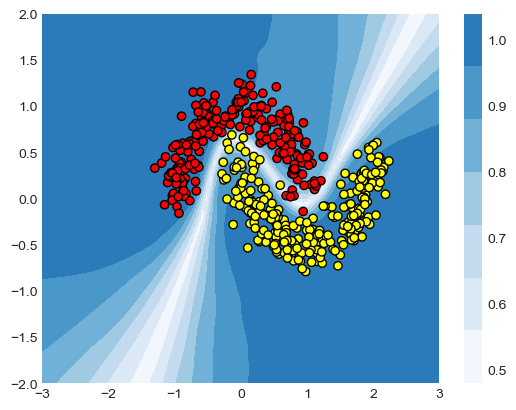

In [13]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))
with torch.no_grad():
    XXYY = torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T)
    out = predict_from_samples(XXYY, network, samples)
    py = out.mean(0)
    conf = torch.where(py > 0.5, py, 1-py)
    ZZ = conf.reshape(XX.shape)
CS = plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.5, vmax=1.2)
plt.colorbar(ticks=np.linspace(0.5, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
#plt.title("Confidence plot");

plt.savefig("Cplot.png", dpi=300, bbox_inches="tight")

## Uncertainty quantification

In [14]:
var_of_prediction = dist.Bernoulli(out.mean(0)).variance
var_of_mean = out.var(0)

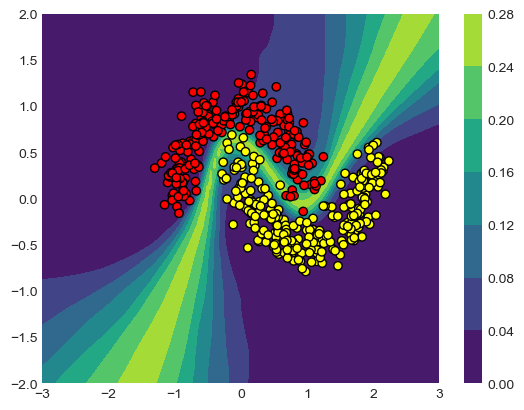

In [15]:
#plt.title("Uncertainty")
plt.contourf(XX, YY, var_of_prediction.reshape(XX.shape), cmap='viridis', vmin=0, vmax=0.3)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');

plt.savefig("Uncertplot.png", dpi=300, bbox_inches="tight")